# EA x DKSG
**classification:**
classify organizations into cause areas based on descriptions
basically, descriptions -> cause areas

## methodology
- clean up organization descriptions
    - drop stopwords
    - drop punctuations
    - lemmatize words
- clean up ea keywords
- create count vectors for each description
- use count vectors as feature for classification with
    - linear regressor
    - decision trees
    - random forest regressor
    - deep LSTM
    
## hypothesis
an organization with certain keywords in its description should be involved in a cause area if the keywords match up with the keywords defined in the cause area

## clean up organization descriptions

In [1]:
## setup
%run env_setup.py
%run filepaths.py
%run helpers.py

In [2]:
web_df = read_from_csv(WEB_SCRAPE_CSV)

In [3]:
web_df.head()

,name,description,website,cause_area,programme_types,address,country,city,contact_number,email,...,Charity.Status,Date.of.Charity.Registration,IPC.Status,IPC.Period,Details.URL,fax,revenue,employees,lat,lon
0,Bali Pink Ribbon - Breast Cancer Awareness Fou...,"Bali Pink Ribbon was founded by Gaye Warren, a...",http://www.balipinkribbon.com,"Balinese People, Health",Our vision is to prevent Indonesian women from...,80113 Dauh Puri Kauh (Denpasar Barat),indonesia,Denpasar,+62 361 4746238,pr@balipinkribbon.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.673612,115.203737
1,Volunteer Programs Bali,"At VP Bali, we believe that education can chan...",http://http://volunteerprogramsbali.org,"Balinese People, Children, Balinese Art & Culture",A dopting the Balinese values and its premise ...,80571 Ubud (Petulu),indonesia,Ubud,NaN,info@volunteerprogramsbali.org,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.675090,115.189919
2,NGO 4 Ger,Only for specials,http://www.fiedbeck.de,Balinese People,NaN,Strasse 1 Bali,indonesia,Amed,+49 7531 123456,h.vergara@fiedbeck.de,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.409518,115.188916
3,Bali Children Foundation,"Our vision, at Bali Children Foundation, is to...",http://www.balichildrenfoundation.org,"Children, Education & Schools",To provide community education in remote areas...,"Jl. Raya Kesambi No.369, Kerobokan, Kuta Utara...",indonesia,Seminyak,+62 361 847 5399,info@balichildrenfoundation.org,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.653567,115.172545
4,Friends of the National Parks Foundation,Friends of the National Park Foundation (FNPF)...,http://www.fnpf.org,Environment & Nature Conservation,"To protect wildlife and its habitat, at the sa...","Ped, Nusapenida, Klungkung Regency, Bali 80771...",indonesia,Pejeng,+62 361 4792286,info@fnpf.org,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.683880,115.518827


In [4]:
## fill up empty descriptions
web_df['description'] = web_df['description'].fillna('')

## add cleaned description
web_df['desc_clean_words'] = get_cleaned_descriptions(list(web_df['description']), True, True, True)
web_df['desc_clean'] = get_sentence_from_list(list(web_df['desc_clean_words']))

In [5]:
## add cleaned cause areas
def clean_cause_area(cause_area_raw):
    words = cause_area_raw.lower().split(",")
    words = [w.strip() for w in words]
    words = [w for w in words if len(w) > 0]
    return set(words)

web_df['cause_area'] = web_df['cause_area'].fillna('')
web_df['cause_area_clean'] = web_df['cause_area'].apply(clean_cause_area)

In [6]:
web_df[['desc_clean_words', 'desc_clean', 'cause_area_clean']].head()

,desc_clean_words,desc_clean,cause_area_clean
0,"[bali, pink, ribbon, found, gaye, warren, brit...",bali pink ribbon found gaye warren british bre...,"{balinese people, health}"
1,"[at, vp, bali, believe, education, change, chi...",at vp bali believe education change childã¢ââ...,"{balinese people, children, balinese art & cul..."
2,"[only, special]",only special,{balinese people}
3,"[our, vision, bali, children, foundation, prov...",our vision bali children foundation provide ed...,"{education & schools, children}"
4,"[friends, national, park, foundation, fnpf, in...",friends national park foundation fnpf indonesi...,{environment & nature conservation}


## clean up ea keywords

In [7]:
ea_df = read_from_csv(EA_CSV)

In [8]:
ea_df.head()

,Causes/ Columns,Keywords_Set 1,Keywords_Set 2,Yad's comments
0,Health infectious diseases,"HIV, AIDs, Tuberculosis, Clinic, Hepatitis, De...","HIV, AIDs, Tuberculosis, Hepatitis, Dengue, Ma...",NaN
1,Neglected tropical diseases (NTDs),"Deworming, parasitic worms, neglected tropical...","Deworming, parasitic worms, neglected tropical...",NaN
2,Social Enterprise,"Social Entrepreneur, business, Entrepreneurshi...","Social Entrepreneur, Entrepreneurship",NaN
3,Environment,"Recycle, Water, plastic, nature, fishery, farm...","Recycle, plastic, pollution, natural resources...",NaN
4,Disaster relief,"Flood, natural disaster, cyclones, earthquakes...","Flood, natural disaster, cyclones, earthquakes...",NaN


In [9]:
ea_df['keywords_clean_words'] = get_cleaned_descriptions(list(ea_df[KEYWORDS_COLUMN]), True, True, True)
ea_df['keywords_clean'] = get_sentence_from_list(list(ea_df['keywords_clean_words']))

In [10]:
ea_df['keywords_clean_words'].head()

0    [hiv, aids, tuberculosis, clinic, hepatitis, d...
1    [deworming, parasitic, worm, neglect, tropical...
2    [social, entrepreneur, business, entrepreneurs...
3    [recycle, water, plastic, nature, fishery, far...
4    [flood, natural, disaster, cyclone, earthquake...
Name: keywords_clean_words, dtype: object

In [11]:
ea_df['keywords_clean'].head()

0    hiv aids tuberculosis clinic hepatitis dengue ...
1    deworming parasitic worm neglect tropical dise...
2    social entrepreneur business entrepreneurship ...
3    recycle water plastic nature fishery farm poll...
4    flood natural disaster cyclone earthquake reli...
Name: keywords_clean, dtype: object

## basic viz

In [12]:
%matplotlib inline
%run viz_setup.py

#### cause areas (web scraped)

In [13]:
from itertools import chain
def get_web_cause_area_summary(web_df):
    df = list(chain.from_iterable(list(web_df['cause_area_clean'].apply(lambda s: list(s)))))
    df = pd.Series(df) 
    df = pd.DataFrame(df.value_counts().reset_index())
    df.columns = ['cause area', 'count']
    
    total_cause_area_count = sum(df['count'])
    df['%'] = df['count'].apply(lambda count: count/total_cause_area_count)
    
    return df

web_cause_area_df = get_web_cause_area_summary(web_df)

Q: top 20 cause areas with highest counts

In [14]:
web_cause_area_df[:20]

,cause area,count,%
0,religious,1085,0.144052
1,education,463,0.061471
2,social and welfare,392,0.052045
3,health,281,0.037307
4,children,251,0.033324
5,charitable,242,0.032130
6,others,232,0.030802
7,environment,225,0.029873
8,support groups,214,0.028412
9,arts and heritage,147,0.019517


Q: cause area by counts bar chart (all)

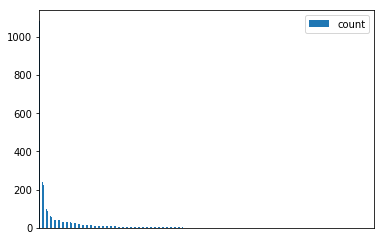

In [15]:
plt = web_cause_area_df.plot.bar(x='cause area', y='count')
plt.xaxis.set_visible(False)

Q: cause area by counts bar chart (top 20)

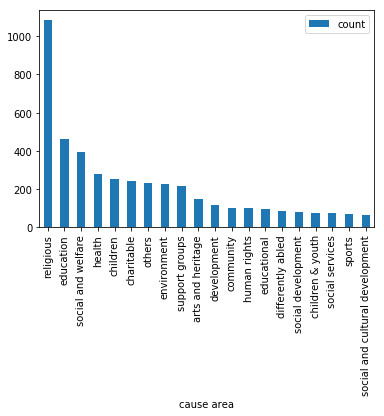

In [16]:
plt = web_cause_area_df[:20].plot.bar(x='cause area', y='count')
plt

Q: total number of unique cause areas

In [17]:
len(web_cause_area_df)

586

Q: total number of organization

In [18]:
sum(web_cause_area_df['count'])

7532

## create features: count vectors for each description
- take top 20 web_cause_areas by count

In [38]:
## ml setup
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import tree
from sklearn import ensemble
from sklearn.metrics import accuracy_score

#### select top 20 cause areas (web scrape)

Q: top 20 cause areas

In [20]:
web_cause_area_select = web_cause_area_df[:20]
set(web_cause_area_select['cause area'])

{'arts and heritage',
 'charitable',
 'children',
 'children & youth',
 'community',
 'development',
 'differently abled',
 'education',
 'educational',
 'environment',
 'health',
 'human rights',
 'others',
 'religious',
 'social and cultural development',
 'social and welfare',
 'social development',
 'social services',
 'sports',
 'support groups'}

Q: proportion of top 20 web cause areas (against all counts)

In [21]:
sum(web_cause_area_select['%'])

0.58271375464684005

create cause_area_clean_filter (ie. a copy of cause_area_clean with only filtered matches)

In [22]:
web_df['cause_area_clean_filter'] = \
    web_df['cause_area_clean'].apply(lambda c: c.intersection(set(web_cause_area_select['cause area'])))

#### select orgs in selected cause areas

In [23]:
def select_orgs_in_cause_area(df, cause_areas):
    matched_indexes = df['cause_area_clean'] \
        .apply(lambda c: len(c.intersection(cause_areas))) \
        .where(lambda count: count > 1) \
        .dropna() \
        .index
    return df.iloc[matched_indexes]

web_df_select = select_orgs_in_cause_area(web_df, set(web_cause_area_select['cause area']))

In [24]:
web_df_select.head()

,name,description,website,cause_area,programme_types,address,country,city,contact_number,email,...,Details.URL,fax,revenue,employees,lat,lon,desc_clean_words,desc_clean,cause_area_clean,cause_area_clean_filter
9,Kupu Kupu Foundation Indonesia,We help improve lives by assisting with medica...,http://www.kupukupufoundation.org,"Children, Health, Education & Schools",Kupu-Kupu Foundation improves the lives of peo...,"Jl. Tirta Tawar No.22, Ubud, Kabupaten Gianyar...",indonesia,Ubud,+62 812 3628720,begonia@kupukupufoundation.org,...,NaN,NaN,NaN,NaN,-8.506246,115.268599,"[we, help, improve, live, assist, medical, car...",we help improve live assist medical care medic...,"{education & schools, children, health}","{children, health}"
10,Yayasan Solemen Indonesia,"Yayasan Solemen Indonesia, an Indonesian regis...",http://www.solemen.org,"Balinese People, Children, Health, General Wel...",Our mission is to help the disadvantaged in Ba...,"80363, Jl. Danau Poso No.55, Sanur Kauh, South...",indonesia,Kuta,+62 0812 3720 6220,info@solemen.org,...,NaN,NaN,NaN,NaN,-8.705537,115.252546,"[yayasan, solemen, indonesia, indonesian, regi...",yayasan solemen indonesia indonesian register ...,"{balinese people, general wellbeing, children,...","{children, health}"
14,Fair Future Foundation,Free healthcare for people in need,http://www.fairfuturefoundation.org,"Balinese People, Children, Health, General Wel...",to improve the daily life of the local communi...,"Jalan Sriwedari 6, Taman Kaja, Ubud, Bali 8051...",indonesia,Ubud,+62 361 975370,info@fairfuturefoundation.org,...,NaN,NaN,NaN,NaN,-8.507416,115.265190,"[free, healthcare, people, need]",free healthcare people need,"{balinese people, general wellbeing, children,...","{children, health}"
26,Yayasan Kemanusiaan Ibu Pertiwi,YKIP (Yayasan Kemanusiaan Ibu Pertiwi) or the ...,http://www.ykip.org,"Children, Health, Education & Schools",Our mission is to restore vision. Our vision i...,"Jalan By Pass Ngurah Rai, Gang Mina Utama No.1...",indonesia,Tuban,+62 361 761208,info@ykip.org,...,NaN,NaN,NaN,NaN,-8.715940,115.220705,"[ykip, yayasan, kemanusiaan, ibu, pertiwi, hum...",ykip yayasan kemanusiaan ibu pertiwi humanitar...,"{education & schools, children, health}","{children, health}"
2557,MÃ¢ÂÂLop Tapang,M'lop Tapang is a comprehensive center dedicat...,NaN,"Education, Health, Economic Empowerment, Right...",NaN,NaN,cambodia,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"[m'lop, tapang, comprehensive, center, dedicat...",m'lop tapang comprehensive center dedicate dis...,"{economic empowerment, rights protection, heal...","{education, health}"


Q: total number of organizations after filtering

In [25]:
len(web_df_select)

258

#### split train/test/validation

In [26]:
train_ratio, test_ratio, validation_ratio_from_test = (0.8,0.2,0.5)

In [27]:
def do_train_test_validation_split(df, train_ratio, test_ratio, validation_ratio_from_test, random_state=None):
    train_data, test_data = \
        train_test_split(df, train_size=train_ratio, test_size=test_ratio, random_state=random_state)
    validation_data, test_data = \
        train_test_split(test_data, train_size=validation_ratio_from_test, 
                          test_size=1-validation_ratio_from_test, random_state=random_state)
            
    return train_data, test_data, validation_data
    
train_data, test_data, validation_data = \
    do_train_test_validation_split(web_df_select, train_ratio, test_ratio, validation_ratio_from_test)

#### encode org descriptions using CountVectorizer

In [28]:
count_vectorizer = CountVectorizer(max_features=100)

train_data_feat = count_vectorizer.fit_transform(train_data['desc_clean'])
test_data_feat = count_vectorizer.transform(test_data['desc_clean'])
validation_data_feat = count_vectorizer.transform(test_data['desc_clean'])

## create labels: cause area categories
#### encode cause area categories to multi-label

In [29]:
mlb = MultiLabelBinarizer()
mlb.fit([web_cause_area_select['cause area']])
mlb.classes_

array(['arts and heritage', 'charitable', 'children', 'children & youth',
       'community', 'development', 'differently abled', 'education',
       'educational', 'environment', 'health', 'human rights', 'others',
       'religious', 'social and cultural development',
       'social and welfare', 'social development', 'social services',
       'sports', 'support groups'], dtype=object)

In [30]:
validation_data.head()

,name,description,website,cause_area,programme_types,address,country,city,contact_number,email,...,Details.URL,fax,revenue,employees,lat,lon,desc_clean_words,desc_clean,cause_area_clean,cause_area_clean_filter
10236,"Kapampangan Development Foundation, Inc.",Company Description:\nThe Kapampangan Developm...,kapampangandevelopmentfoundation.org,"Charitable,Social Development",NaN,"Jesus A. Datu Medical Center, Brgy. San Vicent...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,15.000315,120.652514,"[company, description, \n, the, kapampangan, d...",company description \n the kapampangan develop...,"{social development, charitable}","{social development, charitable}"
10262,"Monark Foundation, Inc.","Company Description:\nMonark Foundation, Inc. ...",www.monarkfoundation.org,"Charitable,Educational",NaN,"13 Economia Street, Bagumbayan, Quezon City",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-22.139555,17.222061,"[company, description, \n, monark, foundation,...",company description \n monark foundation inc. ...,"{educational, charitable}","{educational, charitable}"
3385,MEDRIX,Bring Safe Water to School Kids in Vietnam: Ma...,NaN,"Health, Children, Education, Children, WomenÃ...",NaN,NaN,vietnam,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"[bring, safe, water, school, kids, vietnam, ma...",bring safe water school kids vietnam many chil...,"{womenãâ andãâ girls, education, children, h...","{health, children, education}"
3416,Siam-Care Foundation,Holistic Care for 450 HIV Positive Thai Famili...,NaN,"Children, WomenÃÂ andÃÂ Girls, Health, Human...",NaN,NaN,thailand,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"[holistic, care, 450, hiv, positive, thai, fam...",holistic care 450 hiv positive thai families m...,"{humanãâ rights, health, children, womenãâ a...","{education, children, health}"
10540,All Burma I.t. Student Union,ABITSF - The All Burma I.T StudentsÂ?? Front ...,http://abitsu.org,"Community Service,Educational,Human Rights,",NaN,NaN,thailand,Mae Sot,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"[abitsf, the, all, burma, i.t, studentsâ, fro...",abitsf the all burma i.t studentsâ front form...,"{human rights, educational, community service}","{human rights, educational}"


In [31]:
train_data_label = mlb.transform(train_data['cause_area_clean_filter'])
test_data_label = mlb.transform(test_data['cause_area_clean_filter'])
validation_data_label = mlb.transform(validation_data['cause_area_clean_filter'])

## classify orgs

In [46]:
clf = ensemble.RandomForestClassifier()
clf = clf.fit(train_data_feat, train_data_label)
test_predict = clf.predict(test_data_feat)
train_predict = clf.predict(train_data_feat)

## classifier performance

In [47]:
## accuracy helper
def get_accuracy(true_labels, predicted_labels):
    accuracies = {}
    
    predicted_classes = list(mlb.classes_)
    for cause_area in web_cause_area_select['cause area']:
        index = predicted_classes.index(cause_area)
        accuracy = accuracy_score(
            [a[index] for a in true_labels],
            [a[index] for a in predicted_labels]
        )
        accuracies[cause_area] = accuracy
        
    return accuracies

on train data

In [48]:
get_accuracy(train_data_label, train_predict)

{'arts and heritage': 1.0,
 'charitable': 1.0,
 'children': 1.0,
 'children & youth': 1.0,
 'community': 0.99029126213592233,
 'development': 1.0,
 'differently abled': 1.0,
 'education': 0.99514563106796117,
 'educational': 0.99514563106796117,
 'environment': 0.9854368932038835,
 'health': 0.9854368932038835,
 'human rights': 0.99514563106796117,
 'others': 1.0,
 'religious': 0.99029126213592233,
 'social and cultural development': 1.0,
 'social and welfare': 1.0,
 'social development': 0.99514563106796117,
 'social services': 1.0,
 'sports': 1.0,
 'support groups': 1.0}

on test data

In [49]:
get_accuracy(test_data_label, test_predict)

{'arts and heritage': 1.0,
 'charitable': 1.0,
 'children': 0.69230769230769229,
 'children & youth': 1.0,
 'community': 0.96153846153846156,
 'development': 1.0,
 'differently abled': 1.0,
 'education': 0.73076923076923073,
 'educational': 0.88461538461538458,
 'environment': 0.84615384615384615,
 'health': 0.65384615384615385,
 'human rights': 1.0,
 'others': 1.0,
 'religious': 1.0,
 'social and cultural development': 1.0,
 'social and welfare': 1.0,
 'social development': 0.80769230769230771,
 'social services': 1.0,
 'sports': 1.0,
 'support groups': 1.0}